In [1]:
# Alphalens Analysis
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

In [4]:
# Load Data
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Data/data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('/Volumes/My Book/Data_Analysis', 'Nasdaq', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())   

In [9]:
# Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000721
                           AAPL     -0.001246
                           ABBV      0.001351
                           AIG      -0.000663
                           AMAT     -0.000534
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 251 entries, AAL to MAT
dtypes: float64(251)
memory usage: 1.9 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74030 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74030 non-null  float64
 1   5D               74030 non-null  float64
 2   10D              74030 non-null  float64
 3   21D              74030 non-null  float64
 4   factor           74030 non-null  float64
 5   factor_quantile  74030 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.040679,0.009346,-0.003033,0.004021,14982,20.237741
2,-0.014432,0.011689,-0.000901,0.003301,14857,20.068891
3,-0.012536,0.013446,0.000182,0.003322,14353,19.388086
4,-0.011573,0.015718,0.001200,0.003431,14857,20.068891
5,-0.010150,0.042045,0.003247,0.004251,14981,20.236391


Returns Analysis


,10D,1D,21D,5D
Ann. alpha,0.000,0.000,0.000,0.000
beta,0.000,0.000,0.000,0.000
Mean Period Wise Return Top Quantile (bps),2.149,2.528,1.353,2.692
Mean Period Wise Return Bottom Quantile (bps),-1.389,-2.437,-0.581,-1.591
Mean Period Wise Spread (bps),3.553,4.965,1.909,4.305


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.020,0.023,0.023
IC Std.,0.179,0.172,0.174,0.161
Risk-Adjusted IC,0.105,0.118,0.129,0.142
t-stat(IC),2.879,3.239,3.546,3.876
p-value(IC),0.004,0.001,0.000,0.000
IC Skew,-0.033,-0.067,-0.062,-0.093
IC Kurtosis,-0.145,-0.108,-0.199,0.040


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.302,0.522,0.641,0.740
Quantile 2 Mean Turnover,0.524,0.710,0.763,0.789
Quantile 3 Mean Turnover,0.575,0.736,0.782,0.808
Quantile 4 Mean Turnover,0.523,0.701,0.758,0.794
Quantile 5 Mean Turnover,0.302,0.520,0.651,0.755


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.815,0.557,0.368,0.209


<Figure size 640x480 with 0 Axes>

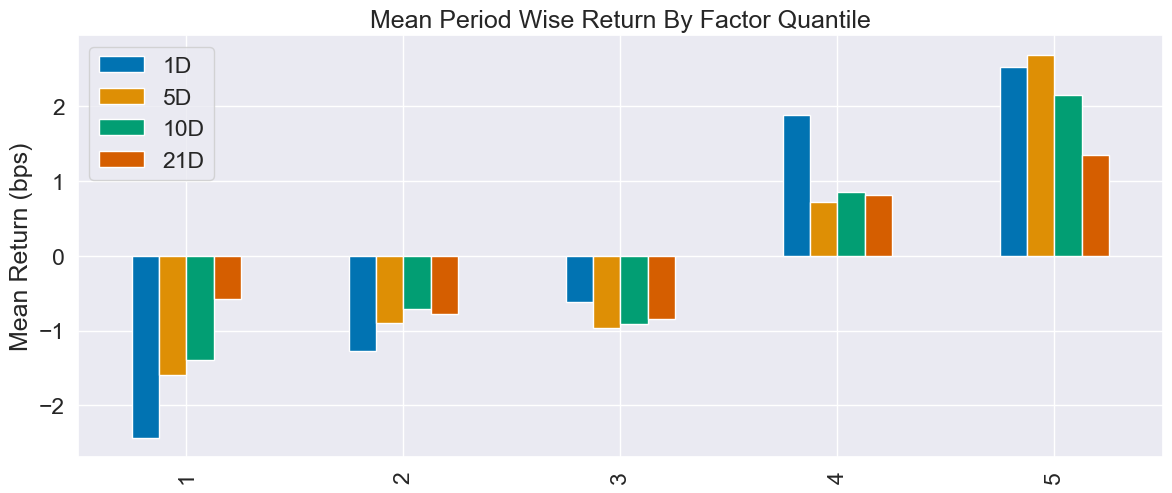

In [13]:
create_summary_tear_sheet(lr_factor_data);

In [14]:
# Ridge Regression
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000703
                           AAPL     -0.001262
                           ABBV      0.001332
                           AIG      -0.000681
                           AMAT     -0.000552
dtype: float64

In [22]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()
print(ridge_factor_data.head())

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74030 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74030 non-null  float64
 1   5D               74030 non-null  float64
 2   10D              74030 non-null  float64
 3   21D              74030 non-null  float64
 4   factor           74030 non-null  float64
 5   factor_quantile  74030 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB
                                       1D        5D       10D       21D  \
date                      asset                                           
2014-12-09 00:00:00+

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.039093,0.009871,-0.003495,0.003835,14982,20.237741
2,-0.012853,0.012212,-0.001365,0.003168,14857,20.068891
3,-0.010959,0.013967,-0.000280,0.003236,14353,19.388086
4,-0.009996,0.016242,0.000735,0.003386,14857,20.068891
5,-0.008574,0.043128,0.002783,0.004286,14981,20.236391


Returns Analysis


,10D,1D,21D,5D
Ann. alpha,0.000,0.000,0.000,0.000
beta,0.000,0.000,0.000,0.000
Mean Period Wise Return Top Quantile (bps),2.130,2.511,1.333,2.696
Mean Period Wise Return Bottom Quantile (bps),-1.394,-2.468,-0.577,-1.589
Mean Period Wise Spread (bps),3.539,4.979,1.886,4.307


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.020,0.023,0.023
IC Std.,0.179,0.172,0.174,0.161
Risk-Adjusted IC,0.105,0.118,0.130,0.142
t-stat(IC),2.882,3.241,3.548,3.876
p-value(IC),0.004,0.001,0.000,0.000
IC Skew,-0.033,-0.067,-0.062,-0.093
IC Kurtosis,-0.144,-0.108,-0.198,0.041


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.302,0.522,0.641,0.740
Quantile 2 Mean Turnover,0.524,0.711,0.763,0.788
Quantile 3 Mean Turnover,0.575,0.737,0.781,0.808
Quantile 4 Mean Turnover,0.523,0.701,0.758,0.794
Quantile 5 Mean Turnover,0.302,0.520,0.651,0.755


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.815,0.557,0.368,0.209


<Figure size 640x480 with 0 Axes>

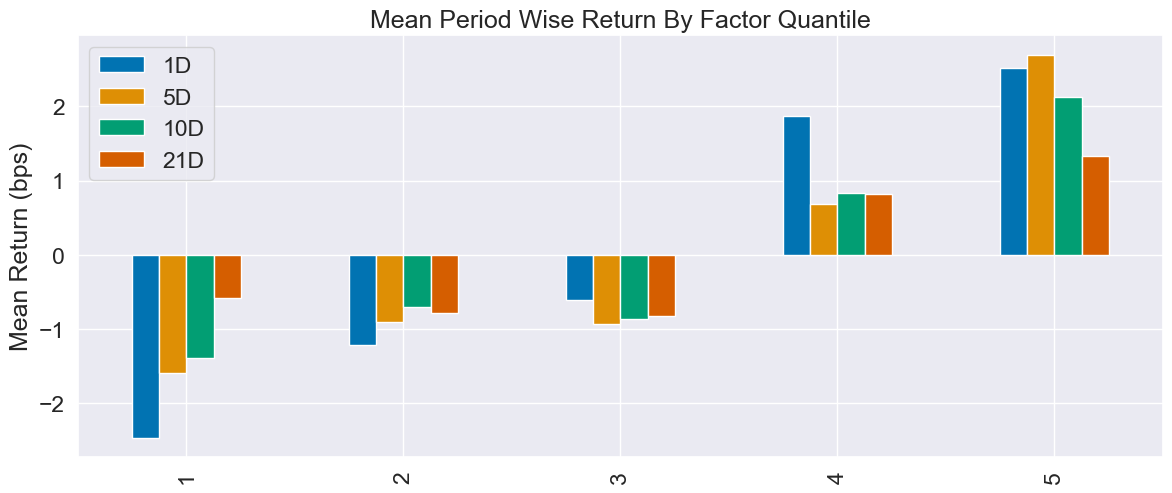

In [17]:
create_summary_tear_sheet(ridge_factor_data);

In [18]:
# Lasso Regression
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000706
                           AAPL     -0.001059
                           ABBV      0.001277
                           AIG      -0.000756
                           AMAT     -0.000558
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74030 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74030 non-null  float64
 1   5D               74030 non-null  float64
 2   10D              74030 non-null  float64
 3   21D              74030 non-null  float64
 4   factor           74030 non-null  float64
 5   factor_quantile  74030 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.038391,0.009841,-0.003362,0.003792,14982,20.237741
2,-0.013370,0.012109,-0.001290,0.003182,14857,20.068891
3,-0.011388,0.013812,-0.000232,0.003272,14353,19.388086
4,-0.010067,0.016113,0.000751,0.003428,14857,20.068891
5,-0.008528,0.042174,0.002746,0.004322,14981,20.236391


Returns Analysis


,10D,1D,21D,5D
Ann. alpha,0.000,0.000,0.000,0.000
beta,0.000,0.000,0.000,0.000
Mean Period Wise Return Top Quantile (bps),2.136,2.497,1.370,2.813
Mean Period Wise Return Bottom Quantile (bps),-1.128,-2.663,-0.448,-1.455
Mean Period Wise Spread (bps),3.281,5.161,1.793,4.292


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.020,0.022,0.021
IC Std.,0.179,0.172,0.174,0.160
Risk-Adjusted IC,0.105,0.119,0.126,0.133
t-stat(IC),2.882,3.245,3.456,3.653
p-value(IC),0.004,0.001,0.001,0.000
IC Skew,-0.034,-0.082,-0.070,-0.090
IC Kurtosis,-0.132,-0.108,-0.180,0.071


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.299,0.520,0.637,0.737
Quantile 2 Mean Turnover,0.518,0.711,0.766,0.790
Quantile 3 Mean Turnover,0.563,0.738,0.781,0.807
Quantile 4 Mean Turnover,0.517,0.698,0.756,0.795
Quantile 5 Mean Turnover,0.302,0.517,0.649,0.755


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.815,0.56,0.37,0.211


<Figure size 640x480 with 0 Axes>

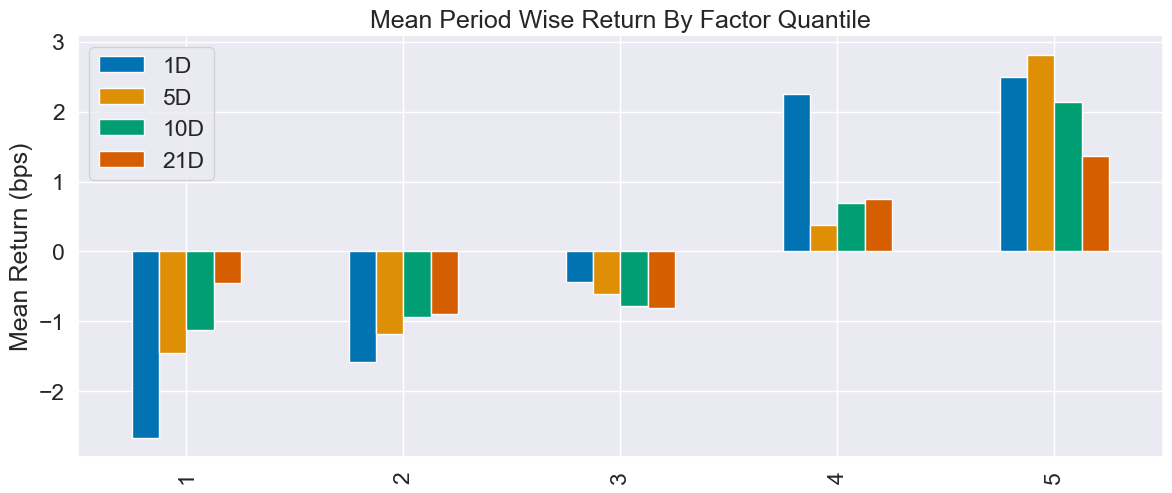

In [21]:
create_summary_tear_sheet(lasso_factor_data);